# Recognizing Hand Gestures

### 1 Setup and Load Data

##### 1.1 Setting dependecies

In [41]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np

##### 1.2 Loading the data

In [42]:
tf.data.Dataset.list_files

<function tensorflow.python.data.ops.dataset_ops.DatasetV2.list_files(file_pattern, shuffle=None, seed=None, name=None) -> 'DatasetV2'>

In [43]:
data = tf.keras.utils.image_dataset_from_directory('data', batch_size=16, color_mode='grayscale', image_size=(300, 300))

Found 1300 files belonging to 4 classes.


In [44]:
data_iterator = data.as_numpy_iterator()

In [45]:
batch = data_iterator.next()

In [46]:
#Images represented as numpy arras: batch[0]
batch[0].shape

(16, 300, 300, 1)

In [47]:
#Labels of the images indicating which class does it belong to: batch[1]
batch[1]

array([1, 2, 1, 1, 1, 3, 3, 1, 1, 1, 3, 0, 1, 2, 0, 1])

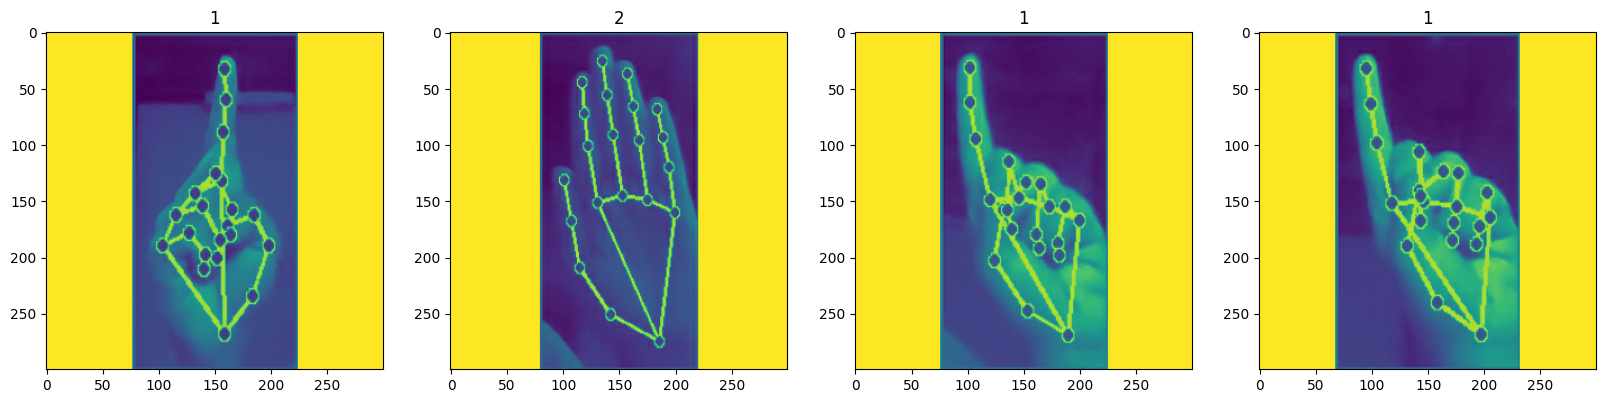

In [48]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

#Class 0: Fist
#Class 1: Like
#Class 2: Palm
#Class 3: Thumb


### 2 Preprocessing Data

#### 2.1 Scale the data

In [49]:
data = data.map(lambda x, y: (x / 255.0, y))

In [50]:
scaled_iterator = data.as_numpy_iterator()

In [51]:
batch = scaled_iterator.next()

In [52]:
batch[0].max()
# batch[0].min()

1.0

In [53]:
batch[0].shape

(16, 300, 300, 1)

#### 2.2 Splitting Data

In [54]:
len(data)

82

In [55]:
train_size = int(len(data)*0.7)
val_size = int(len(data)*0.2)
test_size = int(len(data)*0.1)

In [56]:
test_size

8

In [57]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

### 3 Image Classifer Model

#### 3.1 Build a deep learning model

In [65]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomContrast(0.2)
])

In [70]:
model = models.Sequential([
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 1)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')  
])

In [71]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  
              metrics=['accuracy'])

#### 3.2 Train

In [72]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(train, validation_data=val, epochs=50, callbacks=[early_stopping])


Epoch 1/50


57/57 [==============================] - 32s 539ms/step - loss: 1.2037 - accuracy: 0.5055 - val_loss: 0.6225 - val_accuracy: 0.7812
Epoch 2/50
57/57 [==============================] - 33s 578ms/step - loss: 0.5607 - accuracy: 0.7675 - val_loss: 0.4298 - val_accuracy: 0.8320
Epoch 3/50
57/57 [==============================] - 31s 551ms/step - loss: 0.3923 - accuracy: 0.8531 - val_loss: 0.2539 - val_accuracy: 0.8711
Epoch 4/50
57/57 [==============================] - 30s 532ms/step - loss: 0.3297 - accuracy: 0.8827 - val_loss: 0.1991 - val_accuracy: 0.9375
Epoch 5/50
57/57 [==============================] - 30s 531ms/step - loss: 0.2459 - accuracy: 0.9276 - val_loss: 0.1450 - val_accuracy: 0.9453
Epoch 6/50
57/57 [==============================] - 30s 528ms/step - loss: 0.2014 - accuracy: 0.9287 - val_loss: 0.1528 - val_accuracy: 0.9492
Epoch 7/50
57/57 [==============================] - 30s 529ms/step - loss: 0.2168 - accuracy: 0.9331 - val_loss: 0.2866 - val_accuracy: 0.9023
Epoch 8/50

In [73]:
test_loss, test_accuracy = model.evaluate(test)

# Print test accuracy
print("Test Accuracy:", test_accuracy)

8/8 [==============================] - 1s 119ms/step - loss: 0.0847 - accuracy: 0.9844
Test Accuracy: 0.984375


In [74]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_9 (Sequential)   (None, 300, 300, 1)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 298, 298, 32)      320       
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 149, 149, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 147, 147, 64)      18496     
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 73, 73, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 71, 71, 128)     

#### 3.3 Plotting performance

In [75]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

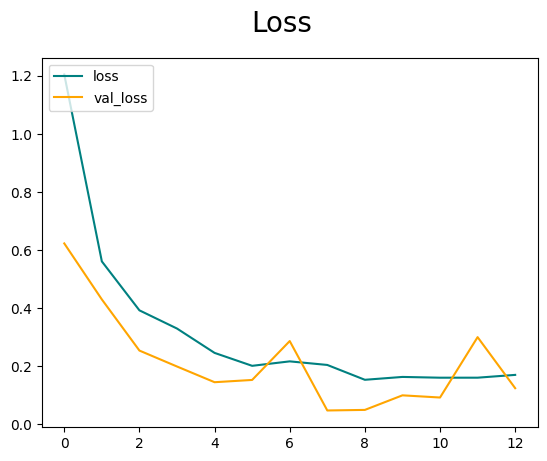

In [76]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

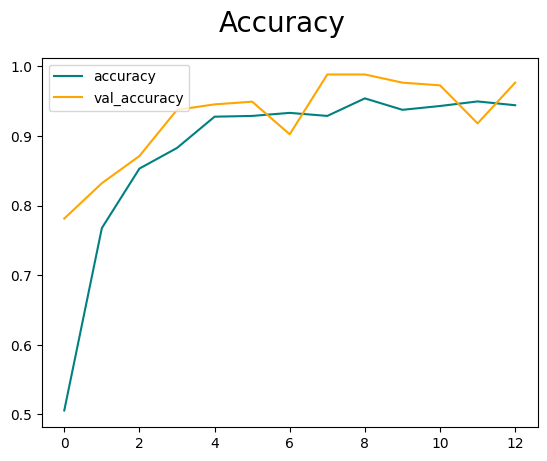

In [77]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

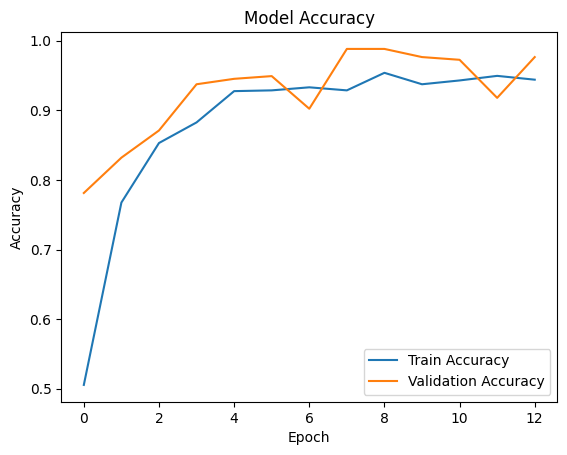

In [78]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [79]:
y_true = []  # List to store the true labels
y_pred = []  # List to store the predicted labels

for batch in test.as_numpy_iterator():
    X, y = batch  # X is input data, y is the true labels
    
    # Append true labels to y_true list
    y_true.extend(y)
    
    # Get model predictions
    predictions = model.predict(X)  # Predictions are typically a probability distribution for each class
    
    # Convert predictions to class labels (e.g., if it's a classification task)
    predicted_classes = np.argmax(predictions, axis=-1)  # Assuming the model outputs a softmax probability distribution
    
    # Append predicted labels to y_pred list
    y_pred.extend(predicted_classes)

# Convert y_true and y_pred to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

1/1 [==============================] - 0s 129ms/step


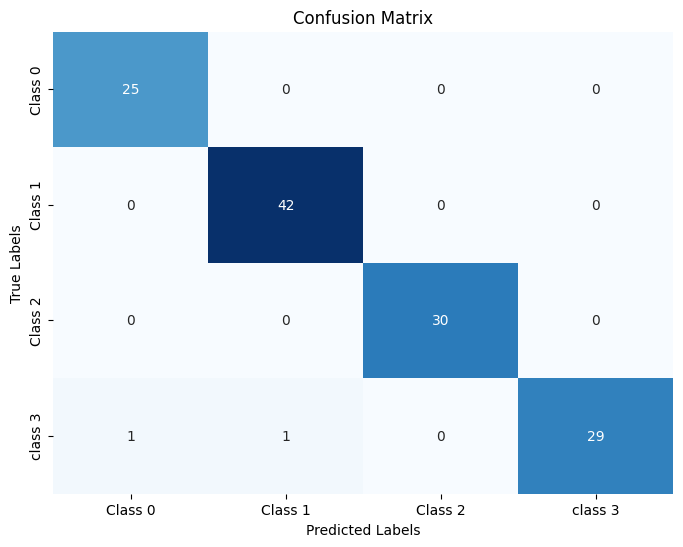

In [80]:
# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Class 0', 'Class 1', 'Class 2', 'class 3'], 
            yticklabels=['Class 0', 'Class 1', 'Class 2', 'class 3'])

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### 4 Evaluate Performacea

#### 4.1 Testing

In [81]:
import cv2

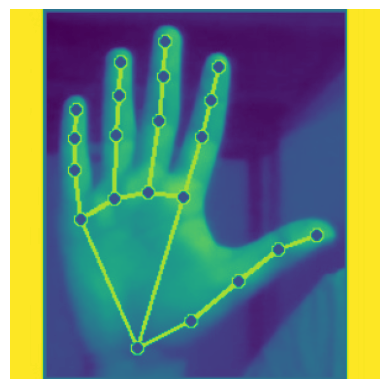

In [82]:
img = cv2.imread('data\palm\Image_1730961009.56237.jpg')

# # Convert the image to grayscale
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# # Resize the grayscale image to the required dimensions (e.g., 256x256)
img_resized = cv2.resize(gray_img, (300, 300))

# # Display the resized grayscale image
plt.imshow(img_resized)
plt.axis('off')
plt.show()

In [83]:
img_expanded = np.expand_dims(img_resized, axis=-1)  # Shape (256, 256, 1)
img_expanded = np.expand_dims(img_expanded, axis=0)   # Shape (1, 256, 256, 1)

# Normalize the pixel values to [0, 1]
img_normalized = img_expanded / 255.0

In [84]:
yhat = model.predict(img_normalized)

1/1 [==============================] - 0s 38ms/step


In [85]:
yhat

array([[0.00673004, 0.00118062, 0.7075665 , 0.28452283]], dtype=float32)

In [86]:
predicted_class = np.argmax(yhat, axis=1)
print("Predicted class:", predicted_class[0])

Predicted class: 2


### 5 Saving the model

#### 5.1 Save the model

In [87]:
import os

In [88]:
from tensorflow.keras.models import  load_model

In [89]:
model.save(os.path.join('models', 'gestureRecognition2.h5'))

d:\VIT\III-Year\Sem 5\AWS\Project\MediaPipe+Tensorflow\myenv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
